# Predicting CLTV and Customer Repeat with Machine Learning for Shopify 

#### A Data Science Analysis Project by Benjamin N. Bellman 

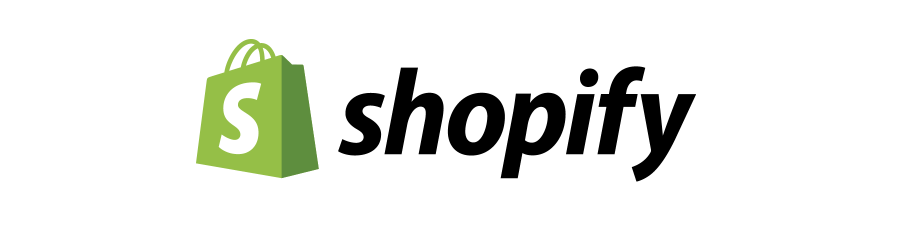

### Project Table of Contents: 

<br> **I. INTRODUCTION \& PRELIMINARY ANALYSIS**
- 1. Project Purpose </font>  
- 2. Loading \& Previewing Data </font>  
- 3. Data Wrangling </font>  
- 4. Preliminary EDA </font>  
 
**II. DATA WRANGLING**  
- 1. Cleaning up data. 
- 2. Creating 3 separate dataframes.
- 3. Creating the final 1 year CLTV Table.

<font color='blue'>**III. EXPLORATORY DATA ANALYSIS**     
- 1. Loading an Previewing the New Table  
- 2. Exploring relationships of variables on Post First Week Spend </font>  

**IV. PREPROCESSING AND MODELLING** 
- 1. Linear Models
- 2. Classification Models


## Part 2: Exploratory Data Analysis

### Loading our packages and Dataframe. 

In [1]:
## We start by importing the appropriate packages which we will want to use. 
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
import warnings
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot 
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split 
from sklearn import linear_model, preprocessing
import scipy
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [2]:
## We load our cleaned data from the previous notebook and name it customer_cltv then preview its headings.
customer_cltv = pd.read_csv('.\..\cleaned_data.csv',index_col=0)
customer_cltv.head()

,CustomerID,pfw_spent,fw_nb_orders,fw_nb_items,fw_total_spent,fw_used_coupon,first_order_month,fw_purchased_accessory,first_item_size,accepts_marketing,wealthy_zip,region,first_item_price_range
0,Anonymous13455,1257.80,1,1,50.0,0,6,0,M,0,0,MW,high
1,Anonymous2142,436.15,1,1,48.0,0,5,0,L,0,0,NE,high
2,Anonymous4843,1052.75,2,2,96.0,0,10,0,S,1,0,W,high
3,Anonymous11225,728.10,1,1,16.0,0,1,1,No size,0,0,MW,low
4,Anonymous540,1114.75,1,1,50.0,0,1,0,XS,0,0,W,high


In [3]:
## Before we begin, let's take a look at the distribution of our post_first week spend 
print(customer_cltv['pfw_spent'].describe())
print('\n')
no_pfw_count = customer_cltv[customer_cltv['pfw_spent'] ==0]['pfw_spent'].count()
pfw_count = customer_cltv[customer_cltv['pfw_spent'] > 0 ]['pfw_spent'].count()
print('Proportion of customers who ordered post first week: ' + str(round(pfw_count/(no_pfw_count+pfw_count),2)))

count    10595.000000
mean        36.267254
std         93.790407
min          0.000000
25%          0.000000
50%          0.000000
75%         32.000000
max       1530.200000
Name: pfw_spent, dtype: float64


Proportion of customers who ordered post first week: 0.27


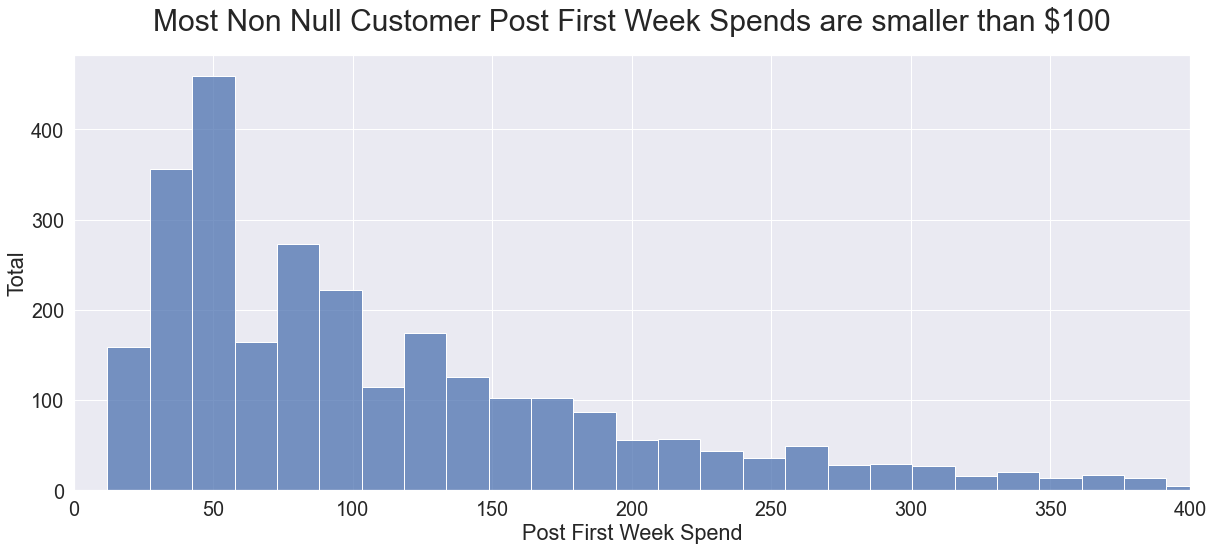

In [34]:
## We visualize the distribution of non-null post first week spend. 
plt.figure(figsize =(20,8))   
sns.histplot(customer_cltv[customer_cltv['pfw_spent'] >0]['pfw_spent'], bins = 100)
plt.xlim(0,400)
plt.xlabel('Post First Week Spend')
plt.ylabel('Total')
plt.title('Most Non Null Customer Post First Week Spends are smaller than $100', fontsize =30, pad =25)
plt.show()

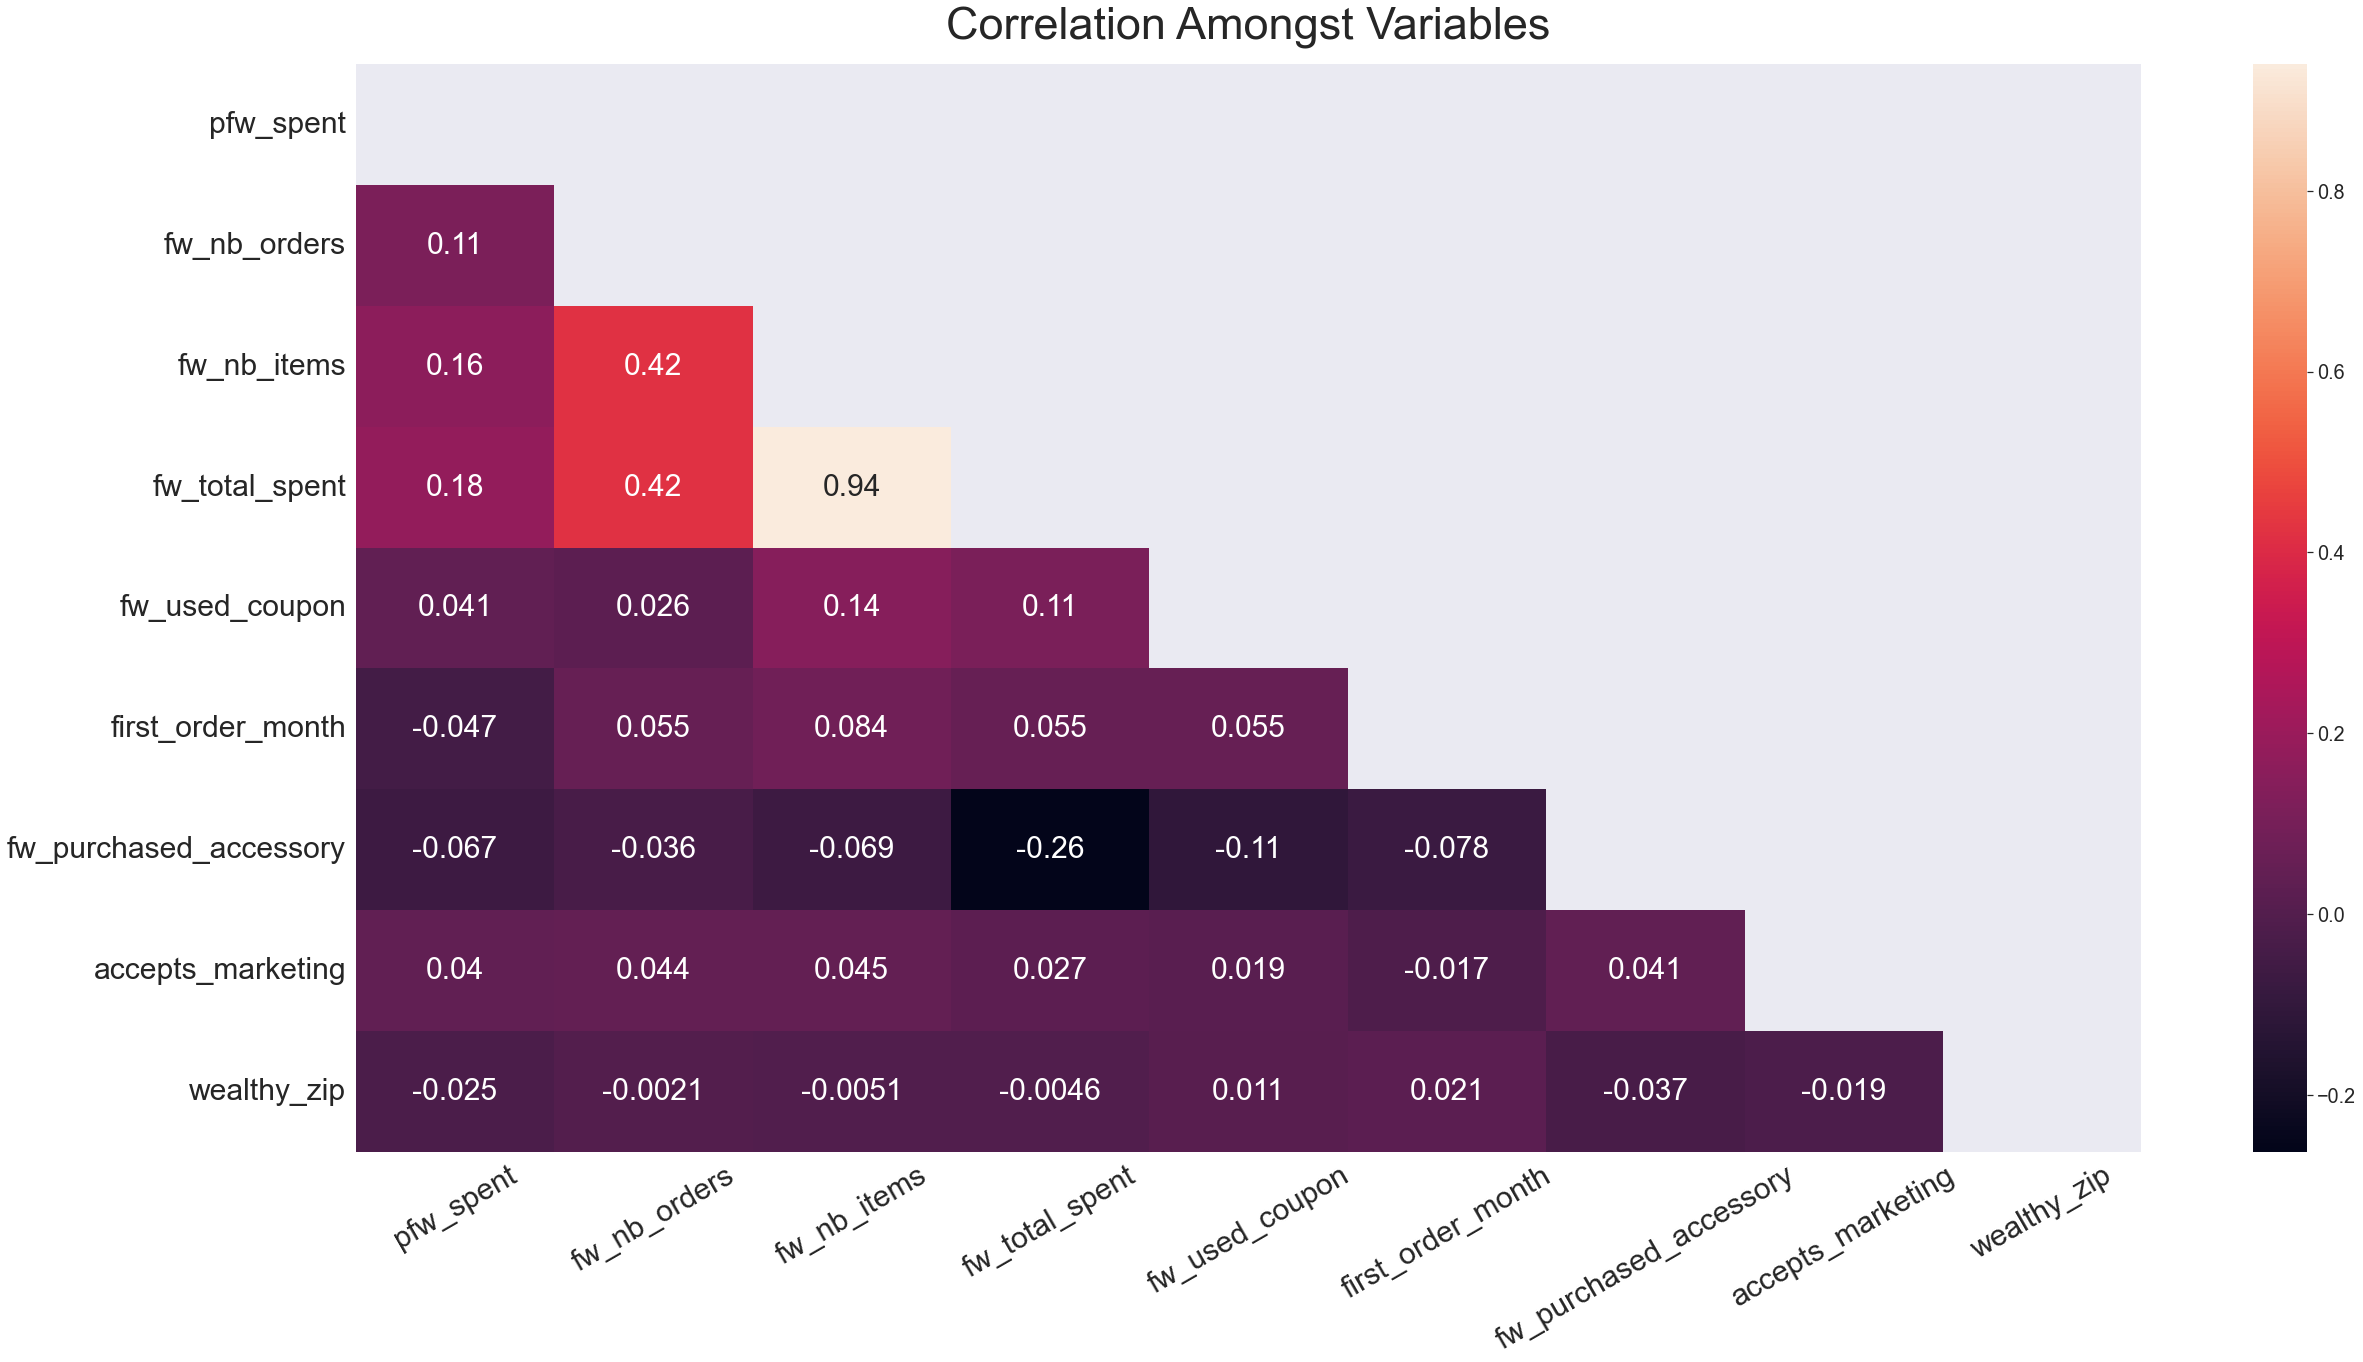

In [5]:
## Prior to exploring the variables,we create a heatmap to get the Pearson Correlation Coefficient amongst the variables. 
## We pay particular attention to the first column, pfw_spent, our target variable.
plt.figure(figsize =(40,20))
sns.set(font_scale=1.8)
sns.heatmap(customer_cltv.corr(), annot =True,annot_kws={"size":30}, mask = np.triu(customer_cltv.corr()))
plt.xticks(fontsize = 30 ,rotation=30) 
plt.yticks(fontsize = 30) 
plt.title('Correlation Amongst Variables', fontsize = 45, pad =25)
plt.show()

### Exploring Variables:

We will exploring the relationships amongst a couple of variables to see if they play a role in influencing our post first week spend. 

<br> **Variables of Interest**
- fw_nb_orders
- fw_nb_items
- fw_total_spend
- fw_used_coupon
- fw_accepts_marketing
- region 
- first_item_size 
- fw_purchased_accessory
- first order month
- wealthy zip code

### 1. Does First Week Spend (FWS) affect Post First Week Spend (PFWS) ?

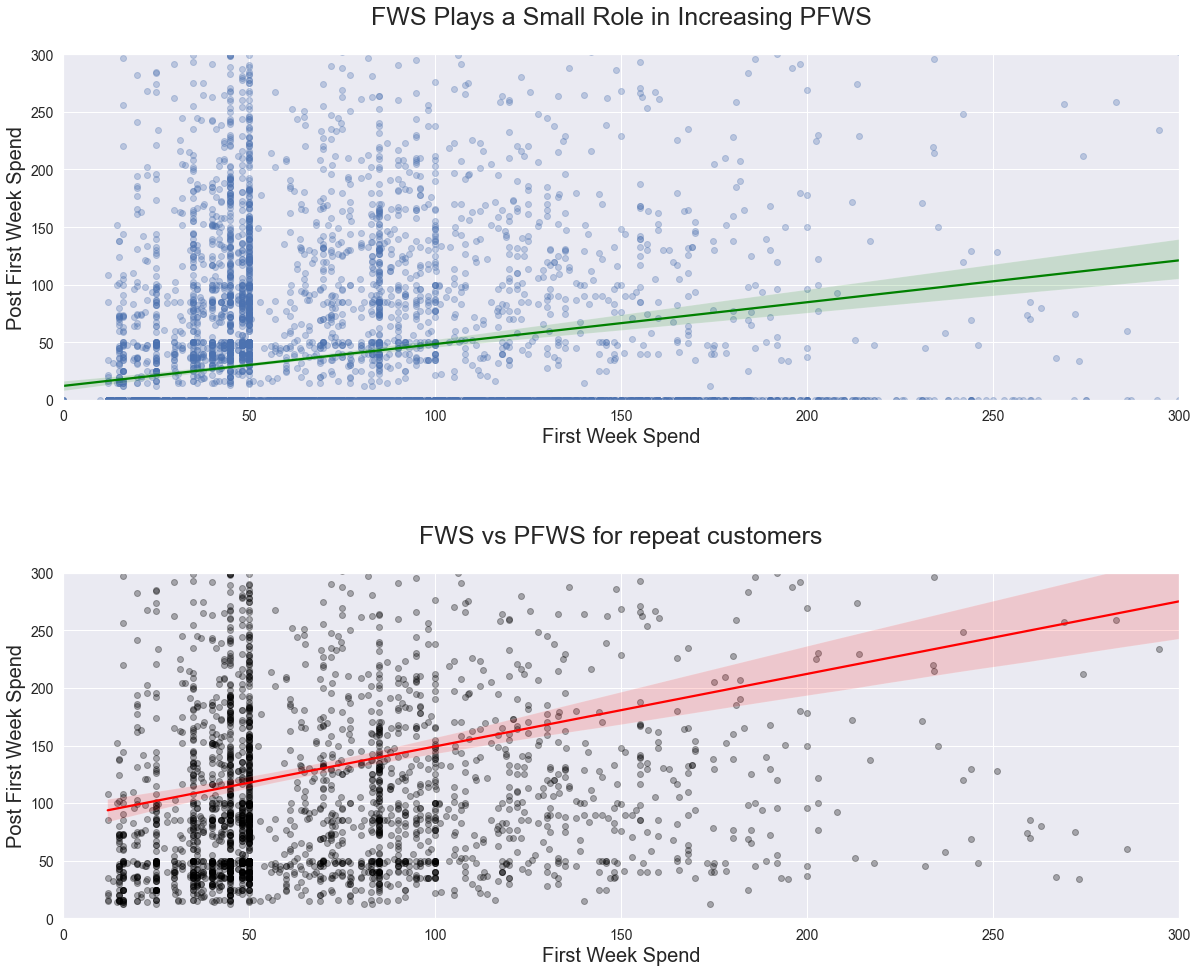

In [6]:
## Let's explore the relationship with a scattergraph. 
fig, axes = plt.subplots(2,1, figsize =(20,8))
plt.subplots_adjust(left=None, bottom=1, right=None, top=2.5, wspace=None, hspace=0.5)

## The first is for all customers regardless of post first week spend
sns.regplot(ax = axes[0], x= 'fw_total_spent',y='pfw_spent', data = customer_cltv,scatter_kws={'alpha':0.3},
            line_kws={"color": "green"})
axes[0].set_title('FWS Plays a Small Role in Increasing PFWS', fontsize = 25, pad=30)
axes[0].set_xlabel('First Week Spend', fontsize =20)
axes[0].set_ylabel('Post First Week Spend', fontsize =20)
axes[0].tick_params(labelsize=14)
axes[0].set_ylim(0,300)
axes[0].set_xlim(0,300)

## The second is for customers whose post first week spend was not 0 (i.e, made purchased past the first week)
sns.regplot(ax = axes[1], x= 'fw_total_spent',y='pfw_spent', data = customer_cltv[customer_cltv['pfw_spent'] > 0],
            scatter_kws={"color": "black",'alpha':0.3},line_kws={"color": "red"})
axes[1].set_title('FWS vs PFWS for repeat customers', fontsize = 25, pad=30)
axes[1].set_xlabel('First Week Spend', fontsize =20)
axes[1].set_ylabel('Post First Week Spend', fontsize =20)
axes[1].tick_params(labelsize=14)
axes[1].set_ylim(0,300)
axes[1].set_xlim(0,300)

plt.show()

### 2. Does First Item Size affect Post First Week Spend (PFWS) ?

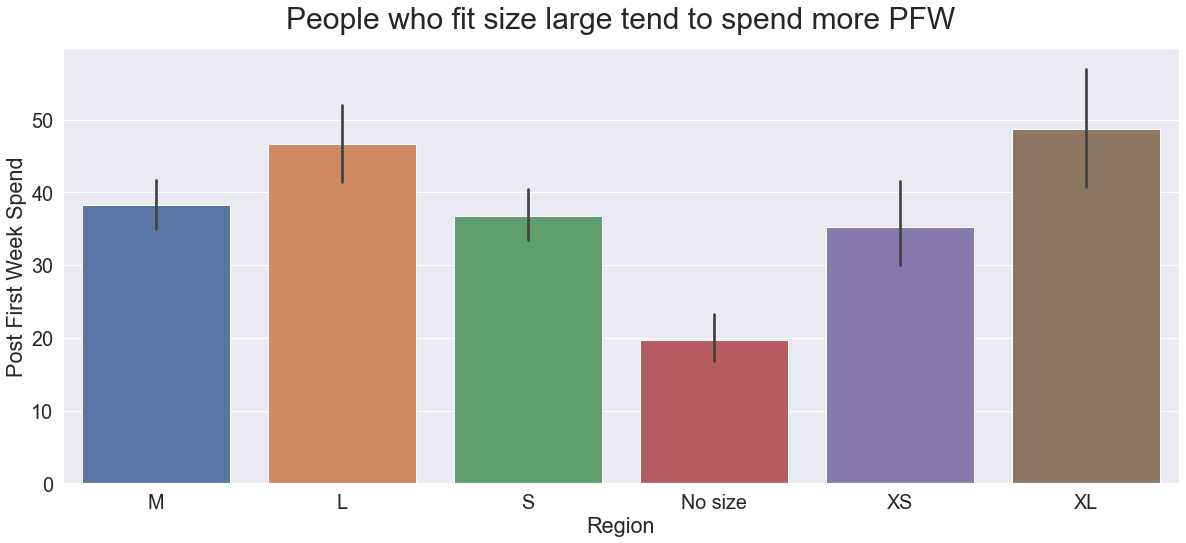

In [7]:
plt.figure(figsize =(20,8))  
sns.color_palette("flare", as_cmap=True)
sns.barplot(x='first_item_size', y='pfw_spent', data = customer_cltv)
#plt.xticks([0,1,2,3],['MidWest','NorthEast','West','South'])
plt.xlabel('Region')
plt.ylabel('Post First Week Spend')
plt.title('People who fit size large tend to spend more PFW', fontsize = 30,pad=20)
plt.show()

## 3. Does Living in a Wealthy Zip Code affect Post First Week Spend (PFWS) ?

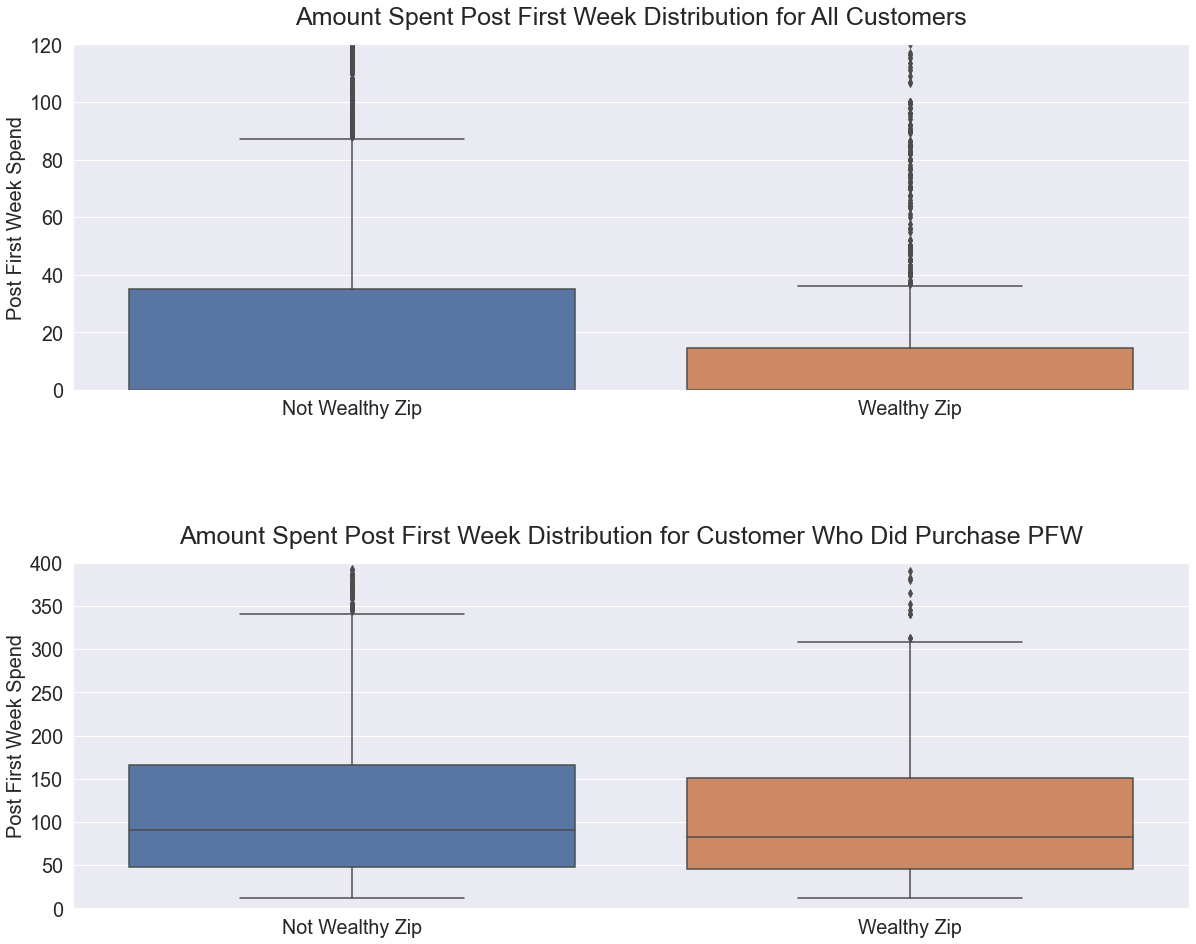

In [8]:
## Let's Visualize the distributions with two boxplots. 
fig, axes = plt.subplots(2,1, figsize =(20,8))
plt.subplots_adjust(left=None, bottom=1, right=None, top=2.5, wspace=None, hspace=0.5)

## The first is for all customers regardless of post first week spend
sns.boxplot(ax = axes[0],x= 'wealthy_zip',y='pfw_spent', data = customer_cltv)
axes[0].set_title('Amount Spent Post First Week Distribution for All Customers', fontsize = 25, pad=20)
axes[0].set_xlabel('')
axes[0].set_ylabel('Post First Week Spend', fontsize =20)
axes[0].set_xticks([0,1],['Not Wealthy Zip', 'Wealthy Zip'])
axes[0].set_ylim(0, 120)

## The second is for customers whose post first week spend was not 0 (i.e, made purchased past the first week)
sns.boxplot(ax = axes[1],x= 'wealthy_zip',y='pfw_spent', data = customer_cltv[customer_cltv['pfw_spent'] > 0])
axes[1].set_title('Amount Spent Post First Week Distribution for Customer Who Did Purchase PFW', fontsize = 25, pad=20)
axes[1].set_xlabel('')
axes[1].set_ylabel('Post First Week Spend', fontsize =20)
axes[1].set_xticks([0,1],['Not Wealthy Zip', 'Wealthy Zip'])
axes[1].set_ylim(0, 400)

plt.show()

In [9]:
print(customer_cltv.groupby('wealthy_zip')['pfw_spent'].mean())
print("\n")
customer_cltv.groupby('wealthy_zip')['pfw_spent'].count()

wealthy_zip
0    37.251208
1    30.706962
Name: pfw_spent, dtype: float64




wealthy_zip
0    9002
1    1593
Name: pfw_spent, dtype: int64

## 4. Does Purchasing an Accessory in the First Week affect Post First Week Spend (PFWS) ? 

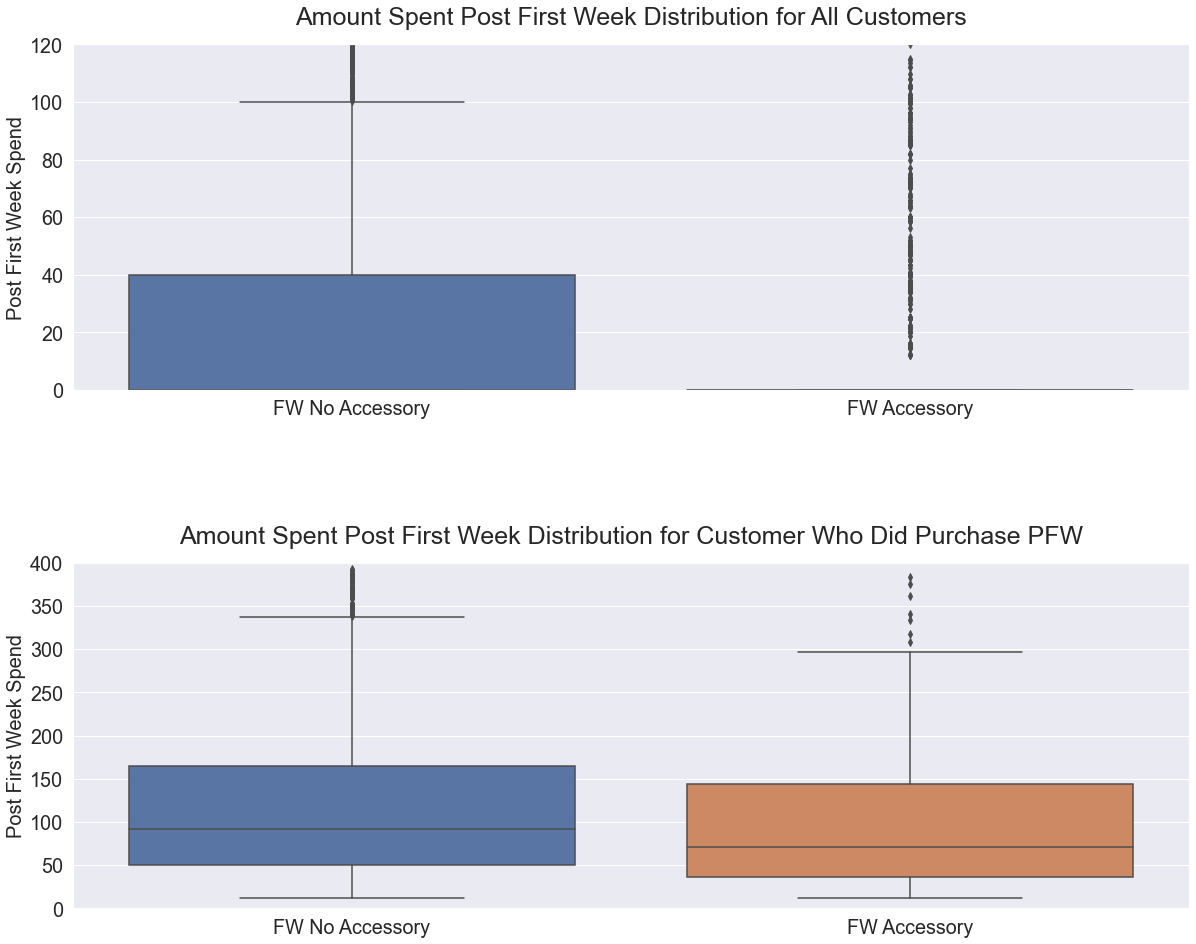

In [10]:
## Let's Visualize the distributions with two boxplots. 
fig, axes = plt.subplots(2,1, figsize =(20,8))
plt.subplots_adjust(left=None, bottom=1, right=None, top=2.5, wspace=None, hspace=0.5)

## The first is for all customers regardless of post first week spend
sns.boxplot(ax = axes[0],x= 'fw_purchased_accessory',y='pfw_spent', data = customer_cltv)
axes[0].set_title('Amount Spent Post First Week Distribution for All Customers', fontsize = 25, pad=20)
axes[0].set_xlabel('')
axes[0].set_ylabel('Post First Week Spend', fontsize =20)
axes[0].set_xticks([0,1],['FW No Accessory', 'FW Accessory'])
axes[0].set_ylim(0, 120)

## The second is for customers whose post first week spend was not 0 (i.e, made purchased past the first week)
sns.boxplot(ax = axes[1],x= 'fw_purchased_accessory',y='pfw_spent', data = customer_cltv[customer_cltv['pfw_spent'] > 0])
axes[1].set_title('Amount Spent Post First Week Distribution for Customer Who Did Purchase PFW', fontsize = 25, pad=20)
axes[1].set_xlabel('')
axes[1].set_ylabel('Post First Week Spend', fontsize =20)
axes[1].set_xticks([0,1],['FW No Accessory', 'FW Accessory'])
axes[1].set_ylim(0, 400)

plt.show()

In [11]:
## Does Purchasing a relatively expensive item in the First Week affect Post First Week Spend (PFWS)  ? 

## 5. Does First Order Month affect PFWS ?

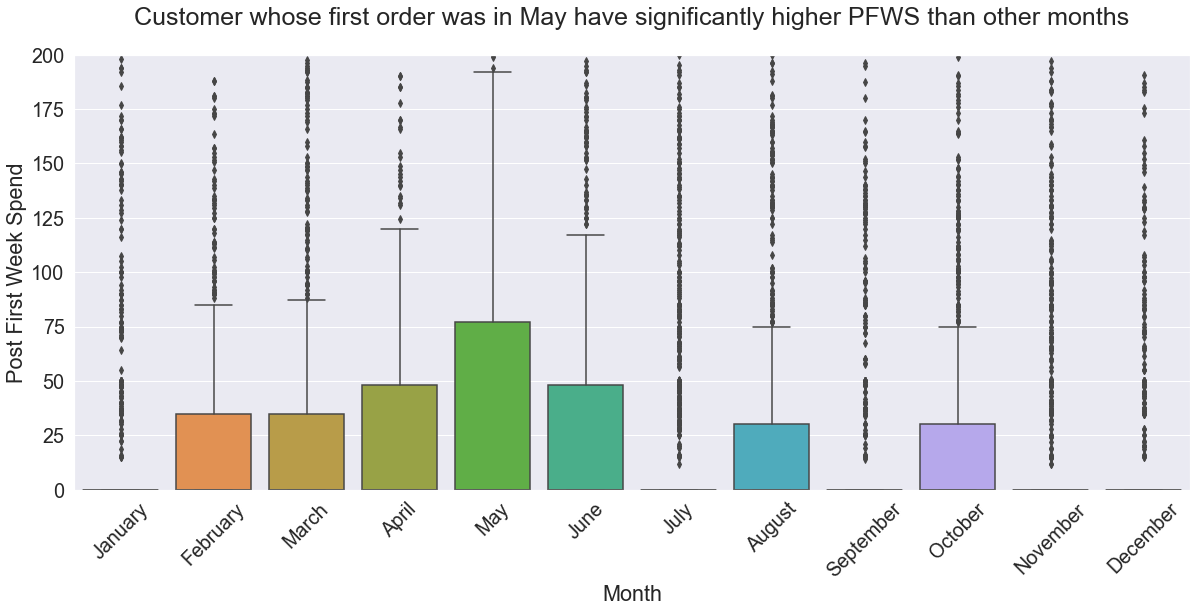

In [12]:
plt.figure(figsize =(20,8))
sns.boxplot(x= 'first_order_month',y='pfw_spent', data = customer_cltv)
plt.xlabel('Month')
plt.ylabel('Post First Week Spend')
plt.title('Customer whose first order was in May have significantly higher PFWS than other months', fontsize = 25,pad=30 )
plt.ylim(0, 200)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11],['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December'], rotation = 45)
plt.show()

In [13]:
print(customer_cltv.groupby('first_order_month')['pfw_spent'].mean())
customer_cltv.groupby('first_order_month')['pfw_spent'].count()

first_order_month
1     31.543389
2     39.492324
3     36.465523
4     41.477896
5     59.220571
6     45.653818
7     32.295072
8     32.682597
9     30.189364
10    35.351122
11    23.709892
12    28.079491
Name: pfw_spent, dtype: float64


first_order_month
1      779
2      697
3      889
4      480
5     1033
6      943
7     1323
8     1009
9      771
10     891
11    1112
12     668
Name: pfw_spent, dtype: int64

# 6. Does Region affect PFWS ?

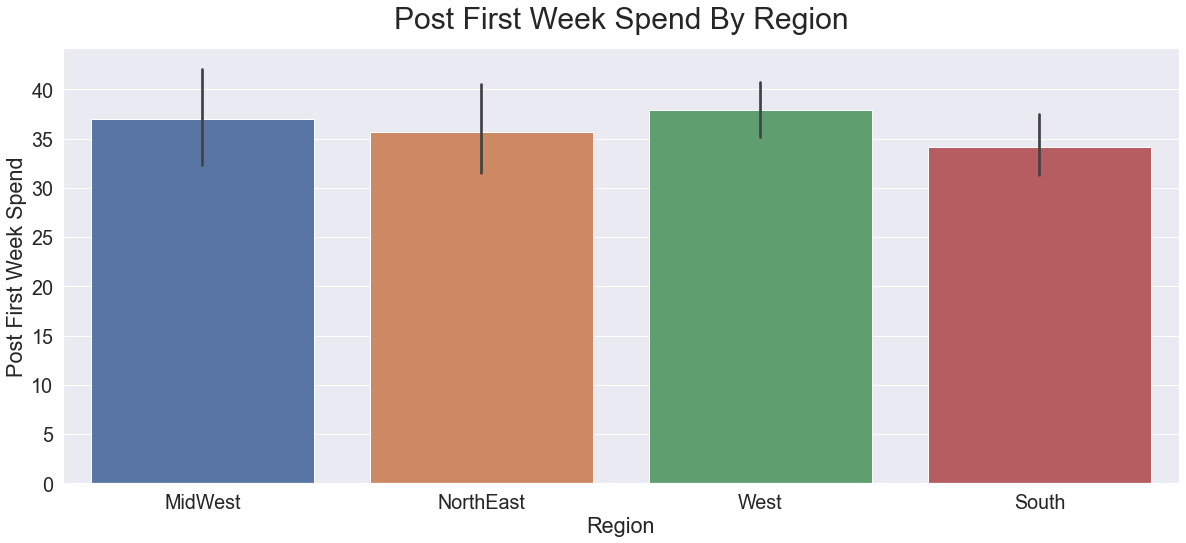

In [14]:
plt.figure(figsize =(20,8))   
sns.barplot(x='region', y='pfw_spent', data = customer_cltv)
plt.xticks([0,1,2,3],['MidWest','NorthEast','West','South'])
plt.xlabel('Region')
plt.ylabel('Post First Week Spend')
plt.title('Post First Week Spend By Region', fontsize = 30,pad=20)
plt.show()

In [15]:
print(customer_cltv.groupby('region')['pfw_spent'].mean())
print('\n')
print('With a max variation of ~$3.50 across the 4 groups, region does not seem to be a good predictor of pfw spend.')

region
MW    36.944562
NE    35.671544
S     34.144820
W     37.875659
Name: pfw_spent, dtype: float64


With a max variation of ~$3.50 across the 4 groups, region does not seem to be a good predictor of pfw spend.


# 7. Does the First Week Number of Orders (FWO) affect PFWS ?

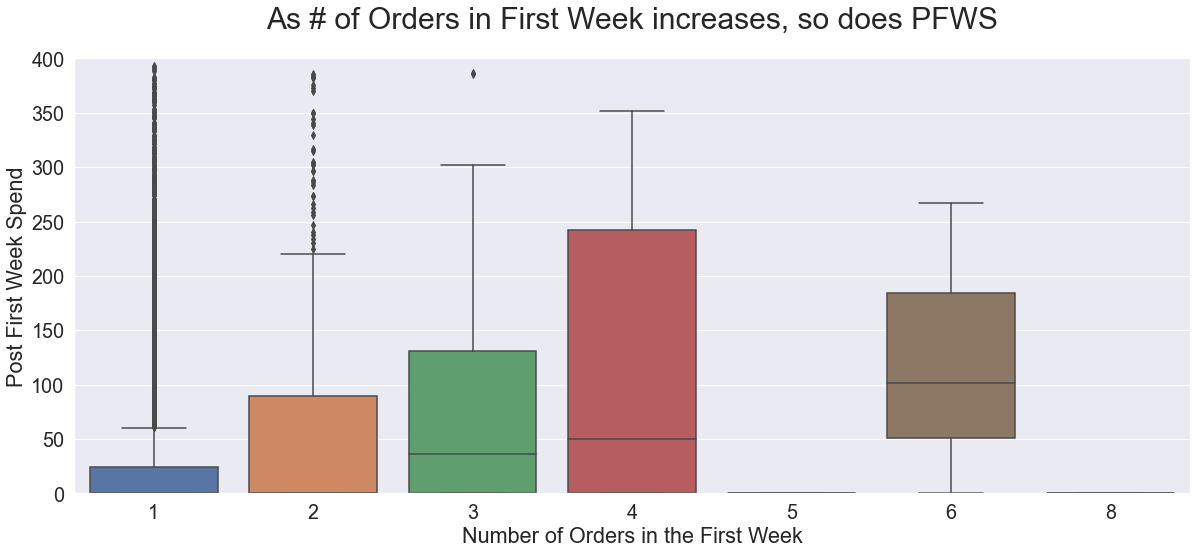

In [16]:
plt.figure(figsize =(20,8))
sns.boxplot(x= 'fw_nb_orders',y='pfw_spent', data = customer_cltv)
plt.xlabel('Number of Orders in the First Week')
plt.ylabel('Post First Week Spend')
plt.title('As # of Orders in First Week increases, so does PFWS', fontsize = 30,pad=30 )
plt.ylim(0, 400)
plt.show()

In [17]:
print("Let's take a look at the distribution:")
print('\n')
print(customer_cltv.fw_nb_orders.value_counts())
print('\n')
print("While it looks like the more orders in the first week, the more the post first week spend increases," "\n"
       "the vast bulk of customers have only made one order, fw_number of items might be a better indicator.")

Let's take a look at the distribution:


1    9968
2     574
3      37
4      11
6       3
8       1
5       1
Name: fw_nb_orders, dtype: int64


While it looks like the more orders in the first week, the more the post first week spend increases,
the vast bulk of customers have only made one order, fw_number of items might be a better indicator.


# 8. Does First Week Number of Items purchased affect Post First Week Spend ? 

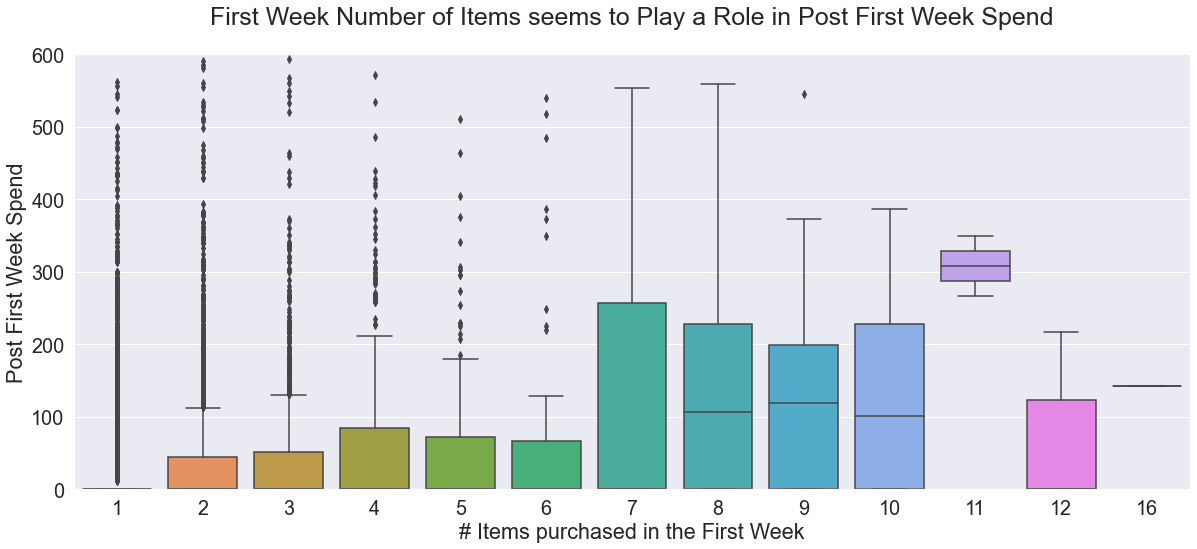

In [18]:
plt.figure(figsize =(20,8))   
sns.boxplot(x= 'fw_nb_items',y='pfw_spent', data = customer_cltv)
plt.xlabel('# Items purchased in the First Week')
plt.ylabel('Post First Week Spend')
plt.title('First Week Number of Items seems to Play a Role in Post First Week Spend', fontsize = 25, pad =30)
plt.ylim(0, 600)
plt.show()

In [19]:
print("Let's take a look at the distribution:")
print(customer_cltv.fw_nb_items.value_counts())
print('\n')
print("This looks to be a better indicator than the first week number of orders and was allready correlated." "\n"
      "Let's perform ANOVA.")

Let's take a look at the distribution:
1     6141
2     2601
3     1012
4      545
5      163
6       66
7       21
8       18
12      10
9        8
10       7
11       2
16       1
Name: fw_nb_items, dtype: int64


This looks to be a better indicator than the first week number of orders and was allready correlated.
Let's perform ANOVA.


In [20]:
import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(customer_cltv[customer_cltv['fw_nb_items'] == 1]['pfw_spent'],
                                customer_cltv[customer_cltv['fw_nb_items'] == 2]['pfw_spent'], 
                                customer_cltv[customer_cltv['fw_nb_items'] == 3]['pfw_spent'], 
                                customer_cltv[customer_cltv['fw_nb_items'] == 4]['pfw_spent'])
print(fvalue, pvalue)
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('pfw_spent ~ C(fw_nb_items)', data=customer_cltv).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

## https://www.reneshbedre.com/blog/anova.html

59.128302975612876 6.832554120695466e-38


,sum_sq,df,F,PR(>F)
C(fw_nb_items),2.787388e+06,12.0,27.189126,1.425679e-61
Residual,9.040422e+07,10582.0,NaN,NaN


## 9 Does Coupon Use in the First Week affect Post First Week Spend ?

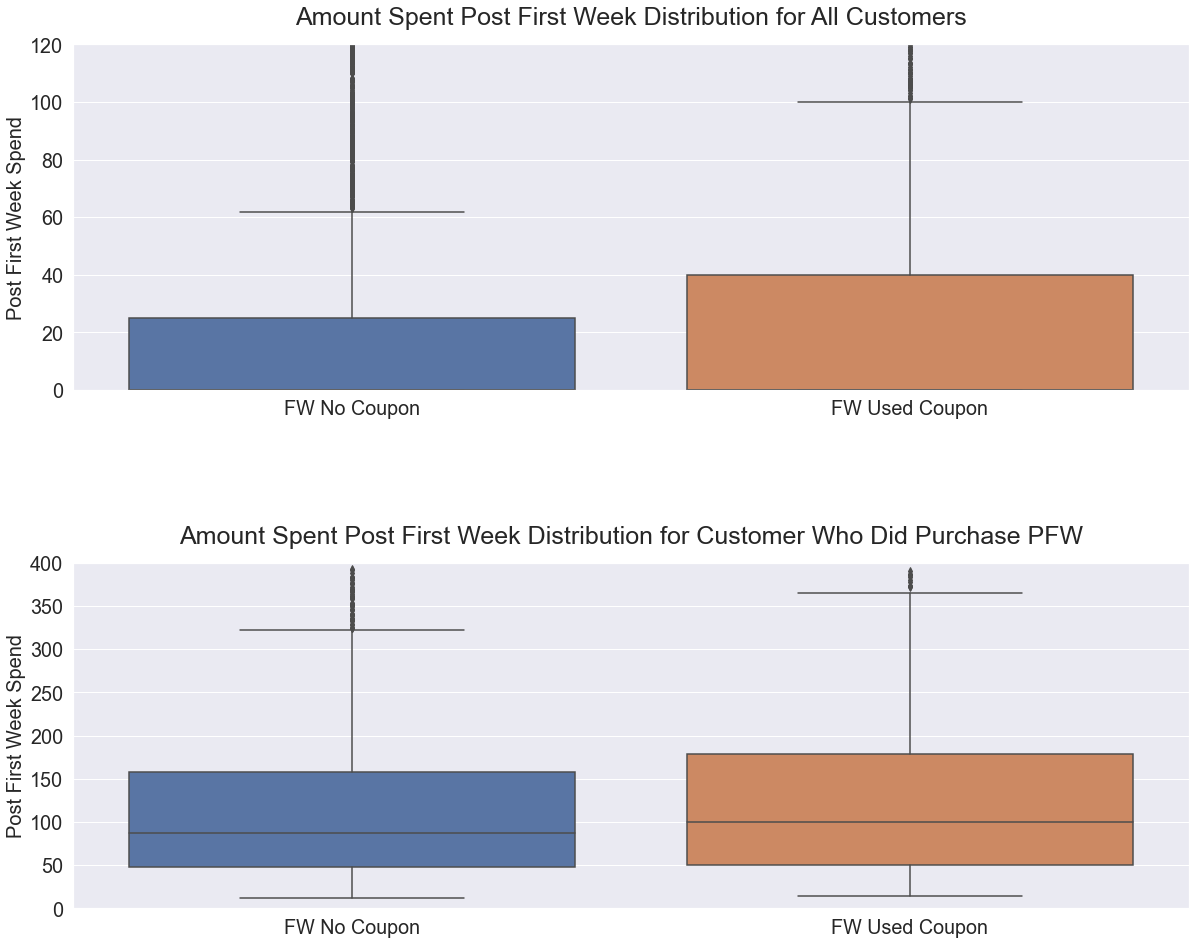

In [21]:
## Let's Visualize the distributions with two boxplots. 
fig, axes = plt.subplots(2,1, figsize =(20,8))
plt.subplots_adjust(left=None, bottom=1, right=None, top=2.5, wspace=None, hspace=0.5)

## The first is for all customers regardless of post first week spend
sns.boxplot(ax = axes[0],x= 'fw_used_coupon',y='pfw_spent', data = customer_cltv)
axes[0].set_title('Amount Spent Post First Week Distribution for All Customers', fontsize = 25, pad=20)
axes[0].set_xlabel('')
axes[0].set_ylabel('Post First Week Spend', fontsize =20)
axes[0].set_xticks([0,1],['FW No Coupon', 'FW Used Coupon'])
axes[0].set_ylim(0, 120)

## The second is for customers whose post first week spend was not 0 (i.e, made purchased past the first week)
sns.boxplot(ax = axes[1],x= 'fw_used_coupon',y='pfw_spent', data = customer_cltv[customer_cltv['pfw_spent'] > 0])
axes[1].set_title('Amount Spent Post First Week Distribution for Customer Who Did Purchase PFW', fontsize = 25, pad=20)
axes[1].set_xlabel('')
axes[1].set_ylabel('Post First Week Spend', fontsize =20)
axes[1].set_xticks([0,1],['FW No Coupon', 'FW Used Coupon'])
axes[1].set_ylim(0, 400)

plt.show()

In [22]:
## Let's look at the means and the differences
customer_cltv.groupby('fw_used_coupon')['pfw_spent'].describe()

,count,mean,std,min,25%,50%,75%,max
fw_used_coupon,,,,,,,,
0,7789.0,33.966828,89.742860,0.0,0.0,0.0,25.0,1257.8
1,2806.0,42.652865,103.955852,0.0,0.0,0.0,40.0,1530.2


In this dataset, it looks like the vast majority did not repurchase

In [23]:
## Let's get the difference in means between both groups.
diff_means = (customer_cltv[customer_cltv['fw_used_coupon'] == 1]['pfw_spent'].mean() -
             customer_cltv[customer_cltv['fw_used_coupon'] == 0]['pfw_spent'].mean())
print('The difference in means between both groups: ~$' + str(round(diff_means,2)))

The difference in means between both groups: ~$8.69


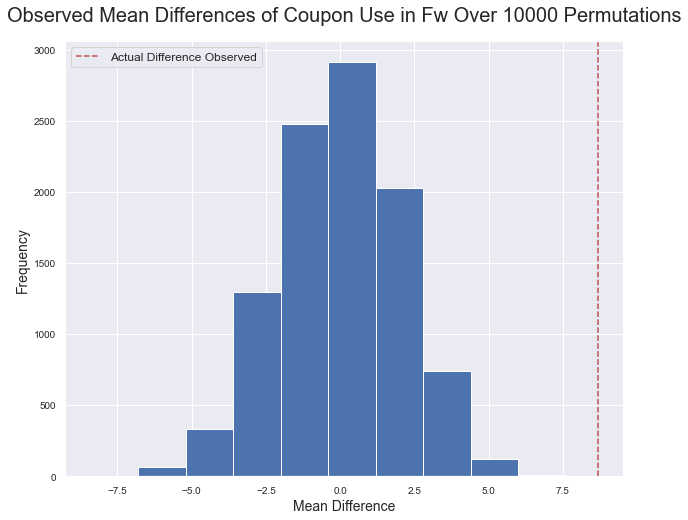

In [24]:
## We will create permutations to look at the observed mean differences
difference = []
for i in range(10000):
    permutation = np.random.permutation(customer_cltv['pfw_spent'])
    difference.append(np.mean(permutation[customer_cltv['fw_used_coupon'] == 0]) - 
                      np.mean(permutation[customer_cltv['fw_used_coupon'] ==1]))

plt.figure(figsize =(10,8))    
plt.hist(difference, bins = 10)
plt.axvline(diff_means,linestyle='--', c='r', label='Actual Difference Observed')
plt.legend(loc=2, fontsize =12)
plt.xlabel('Mean Difference', fontsize =14)
plt.ylabel('Frequency', fontsize =14)
plt.title('Observed Mean Differences of Coupon Use in Fw Over 10000 Permutations', fontsize = 20, pad=20)
plt.xticks(fontsize =10)
plt.yticks(fontsize =10)
plt.show()

In [25]:
## Let's run difference in means test.
scipy.stats.ttest_ind(np.array(customer_cltv[customer_cltv['fw_used_coupon'] == 1]['pfw_spent']), 
                      np.array(customer_cltv[customer_cltv['fw_used_coupon'] == 0]['pfw_spent']))

Ttest_indResult(statistic=4.209591461839883, pvalue=2.5794510588053636e-05)

## 10. Does Opting into Marketing Emails affect Post First Week Spend ?

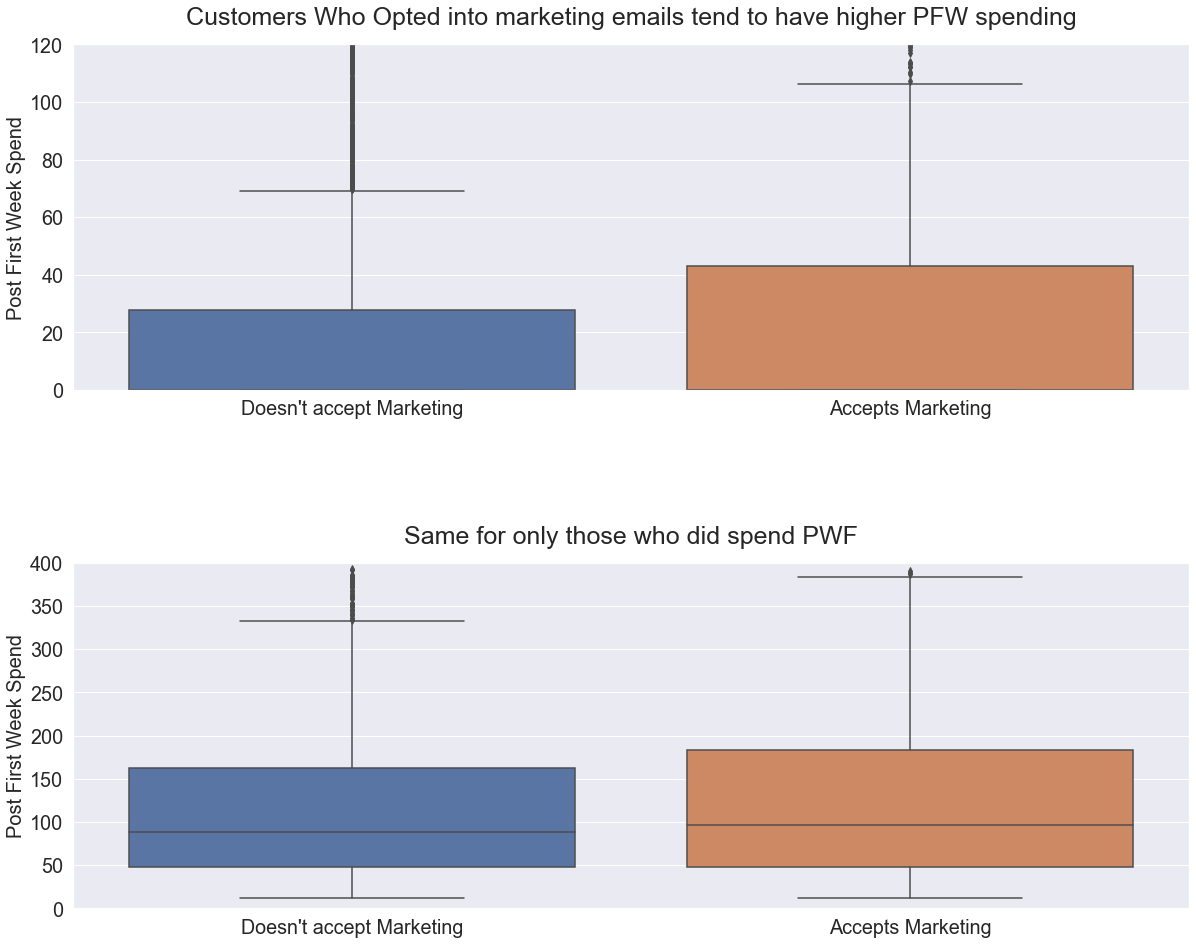

In [26]:
## Let's Visualize the distributions with two boxplots. 
fig, axes = plt.subplots(2,1, figsize =(20,8))
plt.subplots_adjust(left=None, bottom=1, right=None, top=2.5, wspace=None, hspace=0.5)

## The first is for all customers regardless of post first week spend
sns.boxplot(ax = axes[0],x= 'accepts_marketing',y='pfw_spent', data = customer_cltv)
axes[0].set_title('Customers Who Opted into marketing emails tend to have higher PFW spending', fontsize = 25, pad=20)
axes[0].set_xlabel('')
axes[0].set_ylabel('Post First Week Spend', fontsize =20)
axes[0].set_xticks([0,1],["Doesn't accept Marketing", 'Accepts Marketing'])
axes[0].set_ylim(0, 120)


## The second is for customers whose post first week spend was not 0 (i.e, made purchased past the first week)
sns.boxplot(ax = axes[1],x= 'accepts_marketing',y='pfw_spent', data = customer_cltv[customer_cltv['pfw_spent'] > 0])
axes[1].set_title('Same for only those who did spend PWF', fontsize = 25, pad=20)
axes[1].set_xlabel('')
axes[1].set_ylabel('Post First Week Spend', fontsize =20)
axes[1].set_xticks([0,1],["Doesn't accept Marketing", 'Accepts Marketing'])
axes[1].set_ylim(0, 400)

plt.show()

In [27]:
## Let's look at the means and the differences
customer_cltv.groupby('accepts_marketing')['pfw_spent'].describe()

,count,mean,std,min,25%,50%,75%,max
accepts_marketing,,,,,,,,
0,9072.0,34.730931,90.730932,0.0,0.0,0.0,27.75,1530.20
1,1523.0,45.418615,109.859699,0.0,0.0,0.0,42.85,1128.15


In [28]:
## Let's get the difference in means between both groups.
diff_means = (customer_cltv[customer_cltv['accepts_marketing'] == 1]['pfw_spent'].mean() -
             customer_cltv[customer_cltv['accepts_marketing'] == 0]['pfw_spent'].mean())
print('The difference in means between both groups: ~$' + str(round(diff_means,2)))

The difference in means between both groups: ~$10.69


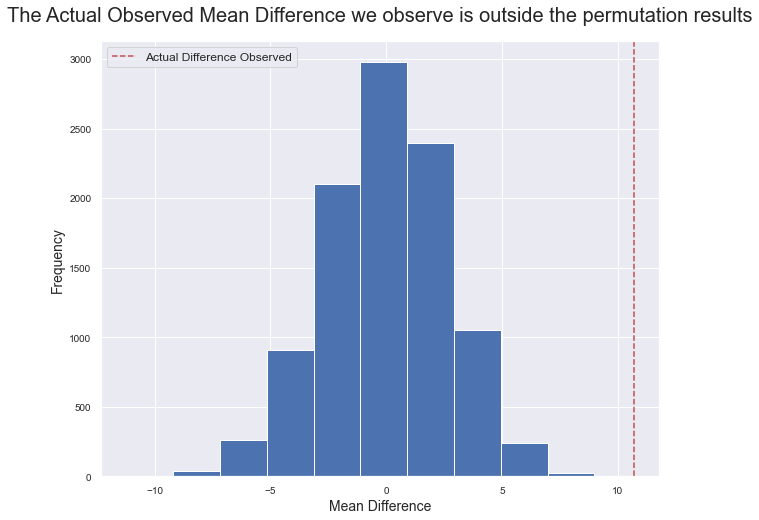

In [29]:
## We will create permutations to look at the observed mean differences
difference = []
for i in range(10000):
    permutation = np.random.permutation(customer_cltv['pfw_spent'])
    difference.append(np.mean(permutation[customer_cltv['accepts_marketing'] == 0]) - 
                      np.mean(permutation[customer_cltv['accepts_marketing'] ==1]))

plt.figure(figsize =(10,8))    
plt.hist(difference, bins = 10)
plt.axvline(diff_means,linestyle='--', c='r', label='Actual Difference Observed')
plt.legend(loc=2, fontsize =12)
plt.xlabel('Mean Difference', fontsize =14)
plt.ylabel('Frequency', fontsize =14)
plt.title('The Actual Observed Mean Difference we observe is outside the permutation results', fontsize = 20, pad=20)
plt.xticks(fontsize =10)
plt.yticks(fontsize =10)
plt.show()

In [30]:
## Let's run difference in means test.
scipy.stats.ttest_ind(np.array(customer_cltv[customer_cltv['accepts_marketing'] == 1]['pfw_spent']), 
                      np.array(customer_cltv[customer_cltv['accepts_marketing'] == 0]['pfw_spent']))

Ttest_indResult(statistic=4.118158074849019, pvalue=3.848126751165667e-05)

In [31]:
## Now let's do the same thing but for theose who did spend PFW
diff_means = (customer_cltv[(customer_cltv['accepts_marketing'] == 1) & (customer_cltv['pfw_spent'] > 0)]['pfw_spent'].mean() -
             customer_cltv[(customer_cltv['accepts_marketing'] == 0) & (customer_cltv['pfw_spent'] > 0)]['pfw_spent'].mean())
print('The difference in means between both groups: ~$' + str(round(diff_means,2)))

The difference in means between both groups: ~$15.12


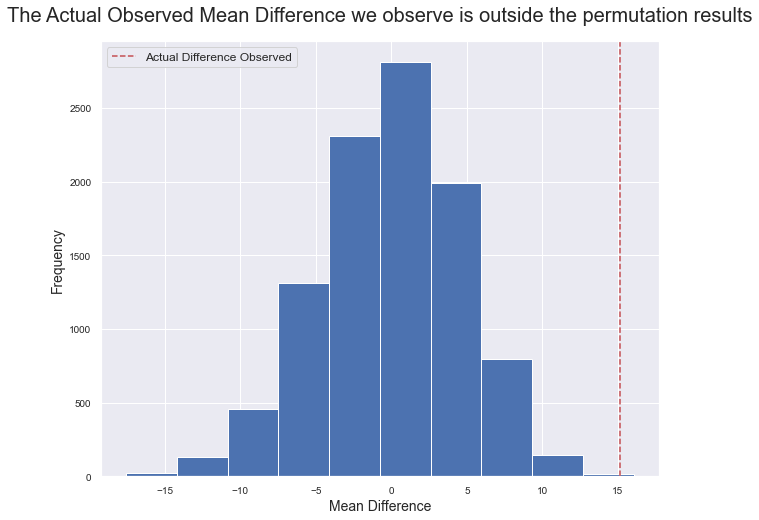

In [32]:
## We will create permutations to look at the observed mean differences
difference = []
for i in range(10000):
    permutation = np.random.permutation(customer_cltv['pfw_spent'])
    difference.append(np.mean(permutation[(customer_cltv['accepts_marketing'] == 0) & (customer_cltv['pfw_spent'] > 0)]) - 
                      np.mean(permutation[(customer_cltv['accepts_marketing'] == 1) & (customer_cltv['pfw_spent'] > 0)]))

plt.figure(figsize =(10,8))    
plt.hist(difference, bins = 10)
plt.axvline(diff_means,linestyle='--', c='r', label='Actual Difference Observed')
plt.legend(loc=2, fontsize =12)
plt.xlabel('Mean Difference', fontsize =14)
plt.ylabel('Frequency', fontsize =14)
plt.title('The Actual Observed Mean Difference we observe is outside the permutation results', fontsize = 20, pad=20)
plt.xticks(fontsize =10)
plt.yticks(fontsize =10)
plt.show()

In [33]:
## Let's run difference in means test.
scipy.stats.ttest_ind(np.array(customer_cltv[(customer_cltv['accepts_marketing'] == 1) & (customer_cltv['pfw_spent'] > 0)]['pfw_spent']), 
                      np.array(customer_cltv[(customer_cltv['accepts_marketing'] == 0) & (customer_cltv['pfw_spent'] > 0)]['pfw_spent']))

Ttest_indResult(statistic=2.1596174204434244, pvalue=0.030884762954402702)